In [1]:
import os
import pickle
import random
import numpy as np
import tqdm
from PIL import Image
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import time

Preprocess the Data

In [2]:
class DataLoader:
    """
    Loads LFW-a dataset splits and converts them into arrays.
    """

    def __init__(self, width, height, cells, data_path, output_path):
        self.width = width
        self.height = height
        self.cells = cells
        self.data_path = data_path
        self.output_path = output_path

    def _open_image(self, path):
        image = Image.open(path)
        image = image.resize((self.width, self.height))
        data = np.asarray(image, dtype='float64')
        return data

    def _construct_image_path(self, person, image_num):
        image_num = str(image_num).zfill(4)
        return os.path.join(self.data_path, 'lfw2', person, f'{person}_{image_num}.jpg')

    def _convert_image_to_array(self, person, image_num, predict=False):
        path = self._construct_image_path(person, image_num)
        image_data = self._open_image(path)
        if not predict:
            image_data = image_data.reshape(self.width, self.height, self.cells)
        return image_data

    def load(self, set_name):
        file_path = os.path.join(self.data_path, f'{set_name}.txt')
        print(f'Loading {set_name} data from {file_path}...')
        x_first, x_second, y, names = [], [], [], []

        with open(file_path, 'r') as file:
            lines = file.readlines()

        for line in tqdm.tqdm(lines):
            parts = line.strip().split()
            if len(parts) == 4:
                p1, img1, p2, img2 = parts
                first_image = self._convert_image_to_array(p1, img1)
                second_image = self._convert_image_to_array(p2, img2)
                x_first.append(first_image)
                x_second.append(second_image)
                y.append(0)
                names.append(parts)
            elif len(parts) == 3:
                p, img1, img2 = parts
                first_image = self._convert_image_to_array(p, img1)
                second_image = self._convert_image_to_array(p, img2)
                x_first.append(first_image)
                x_second.append(second_image)
                y.append(1)
                names.append(parts)
            else:
                print(f'Unexpected line format: {line}')

        print('Done loading dataset. Saving to:', self.output_path)
        with open(self.output_path, 'wb') as f:
            pickle.dump([[x_first, x_second], y, names], f)


Siamese Neural Network

In [3]:
class SiameseNetwork:
    def __init__(self, seed, width, height, cells, loss, metrics, optimizer, dropout_rate, learning_rate=0.001):
        self.seed = seed
        self._set_seed()

        self.width = width
        self.height = height
        self.cells = cells
        self.loss_name = loss
        self.metrics = metrics
        self.dropout_rate = dropout_rate
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.model = self._build_model().to(self.device)

        if optimizer == 'adam':
            self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        else:
            raise ValueError("Only 'adam' optimizer is currently supported.")

        if self.loss_name == 'binary_crossentropy':
            self.criterion = nn.BCELoss()
        else:
            raise ValueError("Only 'binary_crossentropy' is currently supported.")

        self.load_file = None

    def _set_seed(self):
        os.environ['PYTHONHASHSEED'] = str(self.seed)
        random.seed(self.seed)
        np.random.seed(self.seed)
        torch.manual_seed(self.seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(self.seed)

    def initialize_weights(self, tensor):
        if tensor is not None:
            nn.init.normal_(tensor, mean=0.0, std=0.01)

    def initialize_bias(self, tensor):
        if tensor is not None:
            nn.init.normal_(tensor, mean=0.5, std=0.01)

    def _get_cnn_architecture(self, input_shape):
        def init_layer(layer, bias_mean_init=False):
            if hasattr(layer, 'weight') and layer.weight is not None:
                self.initialize_weights(layer.weight)
            if bias_mean_init and hasattr(layer, 'bias') and layer.bias is not None:
                self.initialize_bias(layer.bias)
            return layer

        layers = []
        # Conv blocks
        layers.append(init_layer(nn.Conv2d(self.cells, 64, kernel_size=10), False))
        layers.append(nn.BatchNorm2d(64))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool2d(2))

        conv2 = init_layer(nn.Conv2d(64, 128, kernel_size=7), True)
        layers.append(conv2)
        layers.append(nn.BatchNorm2d(128))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool2d(2))

        conv3 = init_layer(nn.Conv2d(128, 128, kernel_size=4), True)
        layers.append(conv3)
        layers.append(nn.BatchNorm2d(128))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool2d(2))

        conv4 = init_layer(nn.Conv2d(128, 256, kernel_size=4), True)
        layers.append(conv4)
        layers.append(nn.BatchNorm2d(256))
        layers.append(nn.ReLU())

        self.embedding_conv = nn.Sequential(*layers)

        with torch.no_grad():
            dummy = torch.zeros(1, self.cells, self.width, self.height)
            out = self.embedding_conv(dummy)
            flat_size = out.view(1, -1).size(1)

        fc = nn.Linear(flat_size, 4096)
        self.initialize_weights(fc.weight)
        self.initialize_bias(fc.bias)

        embedding = nn.Sequential(
            self.embedding_conv,
            nn.Flatten(),
            fc,
            nn.Sigmoid()
        )

        return embedding

    def _build_model(self):
        class SiameseNet(nn.Module):
            def __init__(inner_self, embedding, dropout_rate):
                super(SiameseNet, inner_self).__init__()
                inner_self.embedding = embedding
                inner_self.dropout = nn.Dropout(dropout_rate)
                inner_self.fc = nn.Linear(4096, 1)
                self.initialize_weights(inner_self.fc.weight)
                self.initialize_bias(inner_self.fc.bias)

            def forward(inner_self, x1, x2):
                out1 = inner_self.embedding(x1)
                out2 = inner_self.embedding(x2)
                dist = torch.abs(out1 - out2)
                dist = inner_self.dropout(dist)
                out = torch.sigmoid(inner_self.fc(dist))
                return out

        embedding = self._get_cnn_architecture((self.width, self.height, self.cells))
        model = SiameseNet(embedding, self.dropout_rate)
        return model

    def _load_weights(self, weights_file):
        if weights_file is None:
            return False
        self.load_file = weights_file
        if os.path.exists(weights_file):
            print('Loading pre-existing weights...')
            self.model.load_state_dict(torch.load(weights_file, map_location=self.device))
            return True
        return False

    def fit(self, weights_file, train_path, validation_size, batch_size, epochs, early_stopping, patience, min_delta):
        with open(train_path, 'rb') as f:
            (X_train, Y_train, _) = pickle.load(f)

        X_train_0, X_val_0, Y_train_split, Y_val_split = train_test_split(X_train[0], Y_train,
                                                                        test_size=validation_size,
                                                                        random_state=self.seed)
        X_train_1, X_val_1, _, _ = train_test_split(X_train[1], Y_train,
                                                    test_size=validation_size,
                                                    random_state=self.seed)

        # Normalize
        X_train_0 = np.array(X_train_0, dtype='float32') / 255.0
        X_val_0 = np.array(X_val_0, dtype='float32') / 255.0
        X_train_1 = np.array(X_train_1, dtype='float32') / 255.0
        X_val_1 = np.array(X_val_1, dtype='float32') / 255.0

        Y_train_final = np.array(Y_train_split, dtype='float32')
        Y_val_final = np.array(Y_val_split, dtype='float32')

        # Reshape: (N, H, W, 1) -> (N,1,H,W)
        X_train_0 = np.transpose(X_train_0, (0, 3, 1, 2))
        X_train_1 = np.transpose(X_train_1, (0, 3, 1, 2))
        X_val_0 = np.transpose(X_val_0, (0, 3, 1, 2))
        X_val_1 = np.transpose(X_val_1, (0, 3, 1, 2))

        # Convert to tensors
        X_train_0_t = torch.from_numpy(X_train_0)
        X_train_1_t = torch.from_numpy(X_train_1)
        Y_train_t = torch.from_numpy(Y_train_final)
        X_val_0_t = torch.from_numpy(X_val_0)
        X_val_1_t = torch.from_numpy(X_val_1)
        Y_val_t = torch.from_numpy(Y_val_final)

        train_data = torch.utils.data.TensorDataset(X_train_0_t, X_train_1_t, Y_train_t)
        val_data = torch.utils.data.TensorDataset(X_val_0_t, X_val_1_t, Y_val_t)

        train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)

        if not self._load_weights(weights_file=weights_file):
            print('No pre-existing weights found. Starting training from scratch.')

        best_val_acc = 0.0
        no_improvement = 0
        history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

        for epoch in range(epochs):
            self.model.train()
            running_loss = 0.0
            running_correct = 0
            total = 0

            for x0, x1, y in train_loader:
                x0, x1, y = x0.to(self.device), x1.to(self.device), y.to(self.device)
                self.optimizer.zero_grad()
                outputs = self.model(x0, x1).squeeze()
                loss = self.criterion(outputs, y)
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item() * y.size(0)
                preds = (outputs >= 0.5).float()
                running_correct += (preds == y).sum().item()
                total += y.size(0)

            train_loss = running_loss / total
            train_acc = running_correct / total

            val_loss, val_acc = self._evaluate_loader(val_loader)
            print(f'Epoch [{epoch+1}/{epochs}] Train Loss: {train_loss:.4f}, '
                f'Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

            history['loss'].append(train_loss)
            history['val_loss'].append(val_loss)
            history['accuracy'].append(train_acc)
            history['val_accuracy'].append(val_acc)

            if early_stopping:
                if val_acc > best_val_acc + min_delta:
                    best_val_acc = val_acc
                    no_improvement = 0
                    torch.save(self.model.state_dict(), weights_file)
                else:
                    no_improvement += 1
                    if no_improvement >= patience:
                        print("Early stopping triggered.")
                        break
            else:
                torch.save(self.model.state_dict(), weights_file)

        if os.path.exists(weights_file):
            self.model.load_state_dict(torch.load(weights_file, map_location=self.device))

        return history

    def _evaluate_loader(self, loader):
        self.model.eval()
        running_loss = 0.0
        running_correct = 0
        total = 0
        with torch.no_grad():
            for x0, x1, y in loader:
                x0, x1, y = x0.to(self.device), x1.to(self.device), y.to(self.device)
                outputs = self.model(x0, x1).squeeze()
                loss = self.criterion(outputs, y)
                running_loss += loss.item() * y.size(0)
                preds = (outputs >= 0.5).float()
                running_correct += (preds == y).sum().item()
                total += y.size(0)

        avg_loss = running_loss / total
        avg_acc = running_correct / total
        return avg_loss, avg_acc

    def evaluate(self, test_file, batch_size, analyze=False):
        with open(test_file, 'rb') as f:
            (X_test, Y_test, names) = pickle.load(f)

        X_test[0] = np.array(X_test[0], dtype='float32') / 255.0
        X_test[1] = np.array(X_test[1], dtype='float32') / 255.0
        Y_test = np.array(Y_test, dtype='float32')

        # Reshape test data to (N,1,H,W)
        X_test[0] = np.transpose(X_test[0], (0, 3, 1, 2))
        X_test[1] = np.transpose(X_test[1], (0, 3, 1, 2))

        X_test_0_t = torch.from_numpy(X_test[0])
        X_test_1_t = torch.from_numpy(X_test[1])
        Y_test_t = torch.from_numpy(Y_test)

        test_data = torch.utils.data.TensorDataset(X_test_0_t, X_test_1_t, Y_test_t)
        test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

        loss, accuracy = self._evaluate_loader(test_loader)
        print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

        if analyze:
            self._analyze(X_test, Y_test, names, batch_size)

        return loss, accuracy

    def _analyze(self, X_test, Y_test, names, batch_size):
        self.model.eval()

        # We assume X_test[0] and X_test[1] are already transposed and normalized if needed.
        X_test_0_t = torch.from_numpy(X_test[0]).to(self.device)
        X_test_1_t = torch.from_numpy(X_test[1]).to(self.device)
        Y_test_t = torch.from_numpy(Y_test).to(self.device)

        test_data = torch.utils.data.TensorDataset(X_test_0_t, X_test_1_t, Y_test_t)
        test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

        probabilities = []
        with torch.no_grad():
            for x0, x1, y in test_loader:
                outputs = self.model(x0, x1).squeeze()
                probabilities.extend(outputs.cpu().numpy())

        best_diff_prob = 1.0
        best_diff_name = None
        worst_diff_prob = 0.0
        worst_diff_name = None

        best_same_prob = 0.0
        best_same_name = None
        worst_same_prob = 1.0
        worst_same_name = None

        for i, (name, y_true) in enumerate(zip(names, Y_test)):
            p = probabilities[i]
            if y_true == 0:
                if p < best_diff_prob:
                    best_diff_prob = p
                    best_diff_name = name
                if p > worst_diff_prob:
                    worst_diff_prob = p
                    worst_diff_name = name
            else:
                if p > best_same_prob:
                    best_same_prob = p
                    best_same_name = name
                if p < worst_same_prob:
                    worst_same_prob = p
                    worst_same_name = name

        print(f'Best diff (correct): {best_diff_name}, prob={best_diff_prob:.4f}')
        print(f'Worst diff (wrong): {worst_diff_name}, prob={worst_diff_prob:.4f}')
        print(f'Best same (correct): {best_same_name}, prob={best_same_prob:.4f}')
        print(f'Worst same (wrong): {worst_same_name}, prob={worst_same_prob:.4f}')


Load Data

In [4]:
# Adjust these paths and parameters according to your setup
data_path = 'Data_HW2'  # Directory containing 'lfw2' and 'splits'
train_output_path = 'Data_HW2/train_data.pkl'
test_output_path = 'Data_HW2/test_data.pkl'

loader = DataLoader(width=105, height=105, cells=1,
                    data_path=data_path,
                    output_path=train_output_path)
loader.load('Train')  # This will create train_data.pkl

loader = DataLoader(width=105, height=105, cells=1,
                    data_path=data_path,
                    output_path=test_output_path)
loader.load('Test')   # This will create test_data.pkl


Loading Train data from Data_HW2/Train.txt...


  0%|          | 0/2200 [00:00<?, ?it/s]

100%|██████████| 2200/2200 [00:22<00:00, 98.13it/s] 


Done loading dataset. Saving to: Data_HW2/train_data.pkl
Loading Test data from Data_HW2/Test.txt...


100%|██████████| 1000/1000 [00:11<00:00, 83.87it/s]


Done loading dataset. Saving to: Data_HW2/test_data.pkl


Experimenting Various Parameters

In [5]:
# Function to run experiments on all combinations of parameters
def run_experiments(train_path, test_path, param_options, epochs=15, patience=5, min_delta=0.001):
    """
    Runs experiments on all combinations of parameters.
    :param train_path: Path to training data.
    :param test_path: Path to test data.
    :param param_options: Dictionary containing parameter lists.
    :param epochs: Number of epochs for training.
    :param patience: Early stopping patience.
    :param min_delta: Early stopping minimum improvement.
    :return: Results dataframe.
    """
    keys, values = zip(*param_options.items())
    combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

    results = []
    history_dict = {}

    for combo in combinations:
        print(f"Running experiment with parameters: {combo}")

        siamese = SiameseNetwork(
            seed=42,
            width=105,
            height=105,
            cells=1,
            loss='binary_crossentropy',
            metrics=['accuracy'],
            optimizer='adam',
            dropout_rate=combo['dropout_rate'],
            learning_rate=combo['learning_rate']
        )



        # Unique weights file for each combination
        unique_weights_file = f"Data_HW2/Model_weights/dropout_{combo['dropout_rate']}_lr_{combo['learning_rate']}_batch_{combo['batch_size']}_es_{combo['early_stopping']}.pt"

        history = siamese.fit(
            weights_file=unique_weights_file,
            train_path=train_path,
            validation_size=0.2,
            batch_size=combo['batch_size'],
            epochs=epochs,
            early_stopping=combo['early_stopping'],
            patience=patience,
            min_delta=min_delta
        )

        history_dict[tuple(combo.values())] = history

        loss, acc = siamese.evaluate(test_file=test_path, batch_size=combo['batch_size'], analyze=False)
        results.append({
            'dropout_rate': combo['dropout_rate'],
            'learning_rate': combo['learning_rate'],
            'batch_size': combo['batch_size'],
            'early_stopping': combo['early_stopping'],
            'test_loss': loss,
            'test_accuracy': acc
        })

    return pd.DataFrame(results), history_dict

# Function to summarize results and plot graphs
def summarize_results(results_df, history_dict):
    """
    Summarizes and visualizes experiment results.
    :param results_df: Dataframe containing experiment results.
    :param history_dict: Dictionary containing training histories for each parameter combination.
    """
    # Display results
    print("\nSummary of Results:")
    print(results_df)

    # Plot individual parameter comparisons
    for param in ['dropout_rate', 'learning_rate', 'batch_size', 'early_stopping']:
        grouped = results_df.groupby(param)['test_accuracy'].agg(['min', 'mean', 'max']).reset_index()
        param_values = grouped[param].astype(str)

        # Positions for grouped bars
        x_labels = ['Min', 'Mean', 'Max']
        bar_width = 0.2  # Width of each bar
        x_positions = np.arange(len(x_labels))  # Base positions for Min, Mean, Max
        
        plt.figure(figsize=(10, 6))
        
        # Plot bars for each parameter value
        for idx, val in enumerate(param_values):
            offset = (idx - len(param_values) / 2) * bar_width  # Offset bars within each group
            plt.bar(x_positions + offset, grouped.iloc[idx, 1:], width=bar_width, label=f'{param}={val}')

        # Add title, labels, and legend
        plt.title(f"Test Accuracy by {param} (Min, Avg, Max)", fontsize=14)
        plt.xlabel("Accuracy Metric", fontsize=8)
        plt.ylabel("Test Accuracy", fontsize=8)
        plt.xticks(x_positions, x_labels, fontsize=12)
        plt.ylim(0.4, 0.8)  # Narrow the range for better visualization of differences
        plt.legend(fontsize=10)

        # Annotate each bar with its value
        for i, pos in enumerate(x_positions):
            for idx in range(len(param_values)):
                value = grouped.iloc[idx, 1 + i]  # Get min/mean/max value for this bar
                offset = (idx - len(param_values) / 2) * bar_width
                plt.text(pos + offset, value + 0.01, f"{value:.2f}", ha='center', fontsize=8)

        plt.tight_layout()
        plt.show()

    # Identify best combination and plot training history
    best_combo = results_df.loc[results_df['test_accuracy'].idxmax()]
    best_history = history_dict.get(tuple(best_combo[['dropout_rate', 'learning_rate', 'batch_size', 'early_stopping']]))
    best_combo_title = f"Best Combo: Dropout={best_combo['dropout_rate']}, LR={best_combo['learning_rate']}, " \
                       f"Batch={best_combo['batch_size']}, EarlyStop={best_combo['early_stopping']}"

    if best_history:
        # Plot loss over epochs
        plt.figure(figsize=(8, 5))
        plt.plot(best_history['loss'], label="Training Loss", linewidth=2) 
        plt.plot(best_history['val_loss'], label="Validation Loss",  linewidth=2)  
        plt.title(f"Loss Over Epochs ({best_combo_title})", fontsize=14)
        plt.xlabel("Epochs", fontsize=12)
        plt.ylabel("Loss", fontsize=12)
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Plot accuracy over epochs
        plt.figure(figsize=(8, 5))
        plt.plot(best_history['accuracy'], label="Training Accuracy", linewidth=2)  
        plt.plot(best_history['val_accuracy'], label="Validation Accuracy", linewidth=2)  
        plt.title(f"Accuracy Over Epochs ({best_combo_title})", fontsize=14)
        plt.xlabel("Epochs", fontsize=12)
        plt.ylabel("Accuracy", fontsize=12)
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print("No valid history data found for the best combination.")

run Experimenting Various Parameters

In [80]:
param_options = {
    'dropout_rate': [0,0.25,0.5],
    'learning_rate': [0.05,0.005,0.0005],
    'batch_size': [16,32,64],
    'early_stopping': [True, False]
}

# Run experiments
results_df, history_dict = run_experiments(
    train_path=train_output_path,
    test_path=test_output_path,
    param_options=param_options,
    epochs=20,
    patience=5
)

Running experiment with parameters: {'dropout_rate': 0, 'learning_rate': 0.05, 'batch_size': 16, 'early_stopping': True}
No pre-existing weights found. Starting training from scratch.
Epoch [1/20] Train Loss: 0.7876, Train Acc: 0.5108 | Val Loss: 0.7104, Val Acc: 0.5205
Epoch [2/20] Train Loss: 0.7038, Train Acc: 0.4960 | Val Loss: 0.7110, Val Acc: 0.4818
Epoch [3/20] Train Loss: 0.6973, Train Acc: 0.5142 | Val Loss: 0.7007, Val Acc: 0.4818
Epoch [4/20] Train Loss: 0.6942, Train Acc: 0.5034 | Val Loss: 0.6982, Val Acc: 0.4841
Epoch [5/20] Train Loss: 0.6952, Train Acc: 0.4892 | Val Loss: 0.6949, Val Acc: 0.4841
Epoch [6/20] Train Loss: 0.6952, Train Acc: 0.4892 | Val Loss: 0.6934, Val Acc: 0.4841
Early stopping triggered.


/tmp/ipykernel_1665871/2004636366.py:312: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(weights_file, map_location=self.device))


Test Loss: 0.7063, Test Accuracy: 0.5330
Running experiment with parameters: {'dropout_rate': 0, 'learning_rate': 0.05, 'batch_size': 16, 'early_stopping': False}
No pre-existing weights found. Starting training from scratch.
Epoch [1/20] Train Loss: 0.8074, Train Acc: 0.5267 | Val Loss: 0.7125, Val Acc: 0.5227
Epoch [2/20] Train Loss: 0.6998, Train Acc: 0.5165 | Val Loss: 0.6997, Val Acc: 0.4932
Epoch [3/20] Train Loss: 0.6977, Train Acc: 0.4909 | Val Loss: 0.6946, Val Acc: 0.4909
Epoch [4/20] Train Loss: 0.6939, Train Acc: 0.4920 | Val Loss: 0.6994, Val Acc: 0.4841
Epoch [5/20] Train Loss: 0.6951, Train Acc: 0.4869 | Val Loss: 0.6955, Val Acc: 0.4841
Epoch [6/20] Train Loss: 0.6951, Train Acc: 0.4892 | Val Loss: 0.6925, Val Acc: 0.4841
Epoch [7/20] Train Loss: 0.6968, Train Acc: 0.5006 | Val Loss: 0.6995, Val Acc: 0.4614
Epoch [8/20] Train Loss: 0.6948, Train Acc: 0.4960 | Val Loss: 0.6969, Val Acc: 0.4841
Epoch [9/20] Train Loss: 0.6948, Train Acc: 0.5165 | Val Loss: 0.6944, Val Acc


Summary of Results:
    dropout_rate  learning_rate  batch_size  early_stopping  test_loss  \
0           0.00         0.0500          16            True   0.706305   
1           0.00         0.0500          16           False   0.701809   
2           0.00         0.0500          32            True   0.694703   
3           0.00         0.0500          32           False   0.695282   
4           0.00         0.0500          64            True   0.698576   
5           0.00         0.0500          64           False   0.693943   
6           0.00         0.0050          16            True   0.677481   
7           0.00         0.0050          16           False   0.685398   
8           0.00         0.0050          32            True   0.650556   
9           0.00         0.0050          32           False   0.613044   
10          0.00         0.0050          64            True   0.641426   
11          0.00         0.0050          64           False   0.635654   
12          0.00 

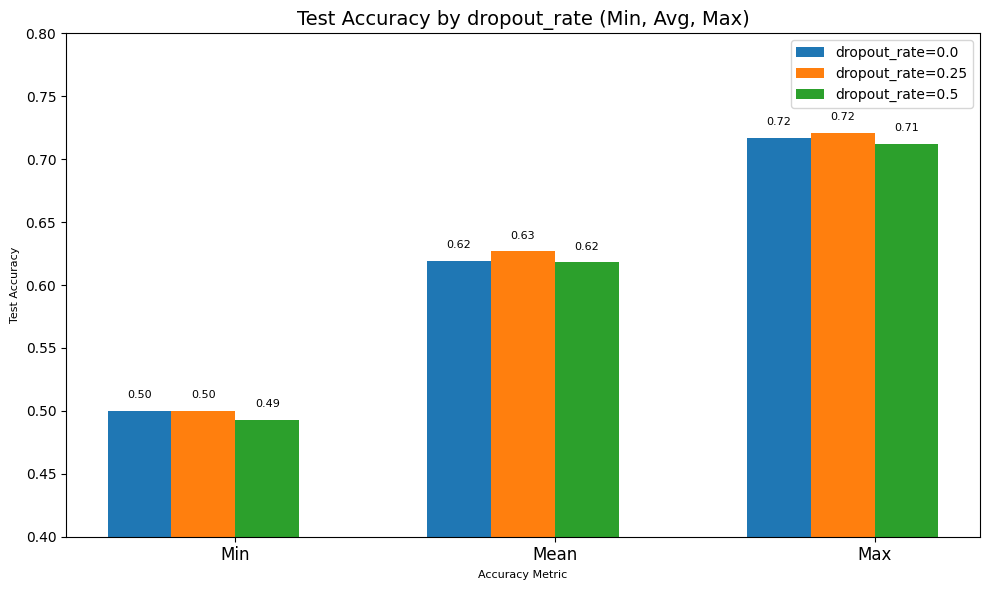

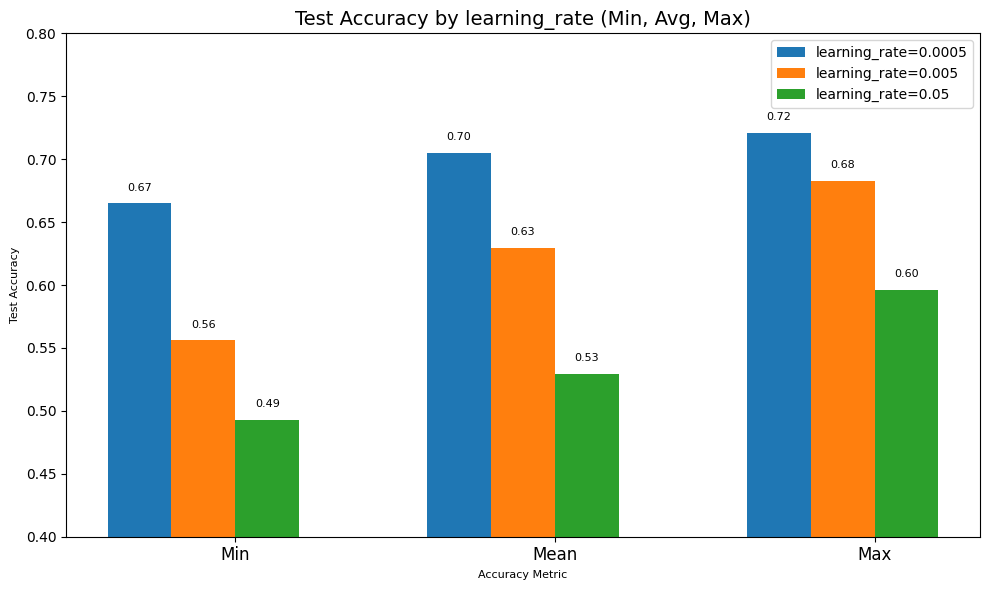

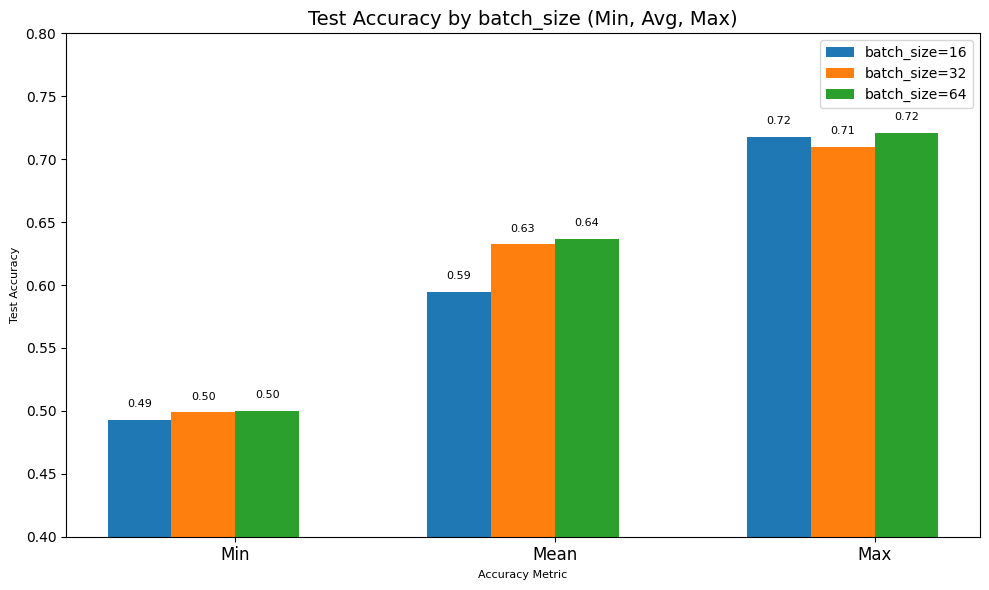

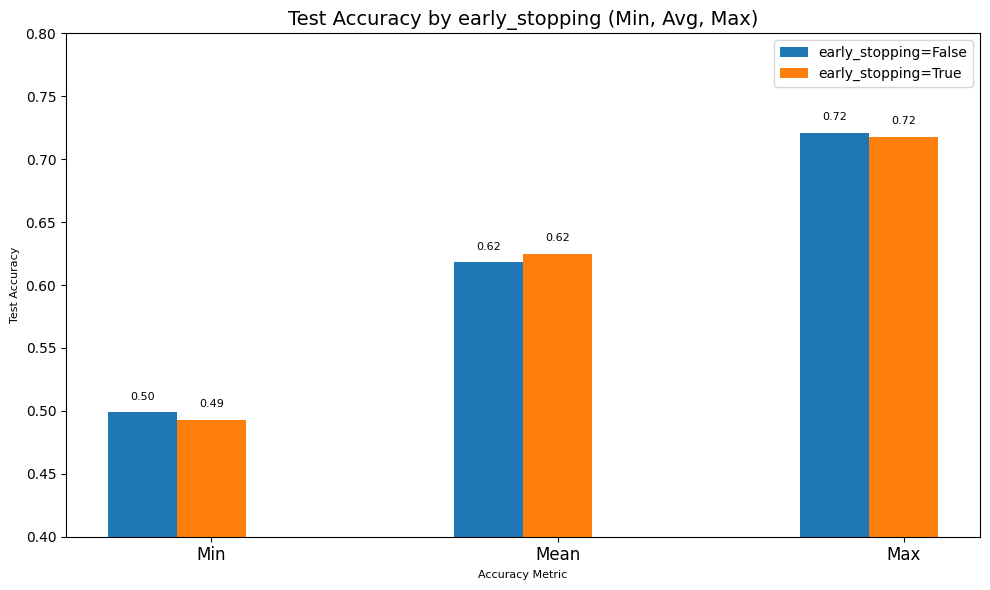

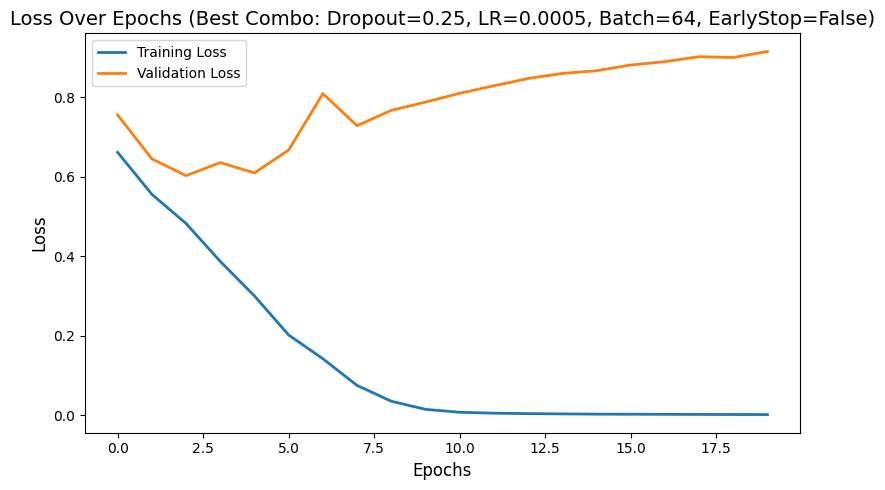

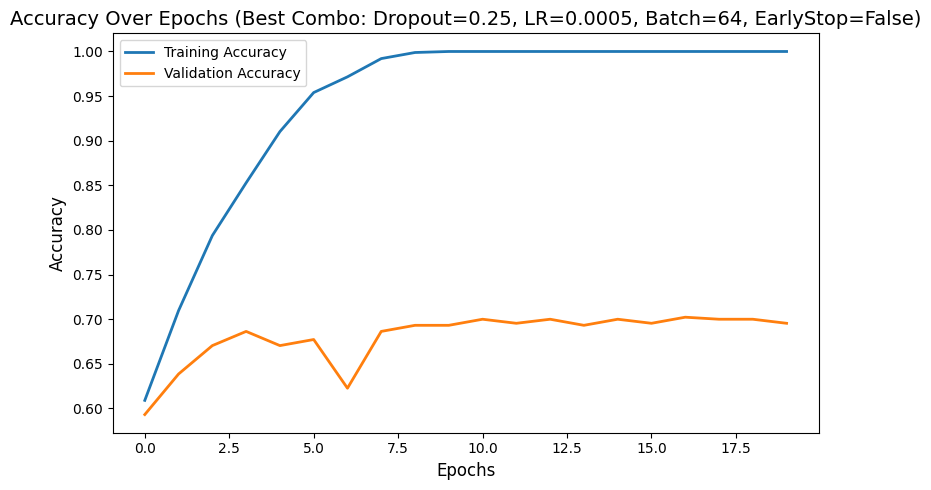

In [107]:
# Summarize results
summarize_results(results_df, history_dict)

Run final model

In [10]:
# Train the Siamese network and measure time
siamese = SiameseNetwork(
    seed=42,
    width=105,
    height=105,
    cells=1,
    loss='binary_crossentropy',
    metrics=['accuracy'],
    optimizer='adam',
    dropout_rate=0.25,
    learning_rate=0.0005
)

start_time = time.time()
history = siamese.fit(
    weights_file='Data_HW2/Model_weights/model_weights_new.pt',  # Save model weights
    train_path=train_output_path,
    validation_size=0.2,
    batch_size=64,
    epochs=20,
    early_stopping=True,
    patience=5,
    min_delta=0.001
)
end_time = time.time()


No pre-existing weights found. Starting training from scratch.
Epoch [1/20] Train Loss: 0.6692, Train Acc: 0.6023 | Val Loss: 0.7366, Val Acc: 0.5705
Epoch [2/20] Train Loss: 0.5622, Train Acc: 0.7170 | Val Loss: 0.6027, Val Acc: 0.6705
Epoch [3/20] Train Loss: 0.4953, Train Acc: 0.7716 | Val Loss: 0.6027, Val Acc: 0.6705
Epoch [4/20] Train Loss: 0.4004, Train Acc: 0.8409 | Val Loss: 0.5983, Val Acc: 0.6705
Epoch [5/20] Train Loss: 0.3051, Train Acc: 0.9051 | Val Loss: 0.6104, Val Acc: 0.6818
Epoch [6/20] Train Loss: 0.2119, Train Acc: 0.9489 | Val Loss: 0.6341, Val Acc: 0.6545
Epoch [7/20] Train Loss: 0.1491, Train Acc: 0.9716 | Val Loss: 0.7599, Val Acc: 0.6591
Epoch [8/20] Train Loss: 0.0753, Train Acc: 0.9938 | Val Loss: 0.7309, Val Acc: 0.7000
Epoch [9/20] Train Loss: 0.0313, Train Acc: 1.0000 | Val Loss: 0.7613, Val Acc: 0.6841
Epoch [10/20] Train Loss: 0.0143, Train Acc: 1.0000 | Val Loss: 0.7759, Val Acc: 0.7045
Epoch [11/20] Train Loss: 0.0073, Train Acc: 1.0000 | Val Loss: 0.

/tmp/ipykernel_2956947/2004636366.py:312: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(weights_file, map_location=self.device))


Prediction Labels and Evaluation final model

Training completed in 66.51 seconds.
Test Loss: 0.8826, Test Accuracy: 0.7060
Test Loss: 0.8826, Test Accuracy: 0.7060
True Positive Examples:
Pair: ['Calista_Flockhart', '2', '6'], Model Probability: 0.99, True Label: 1
Pair: ['Doug_Collins', '1', '2'], Model Probability: 0.99, True Label: 1
Pair: ['Leonardo_DiCaprio', '1', '8'], Model Probability: 0.97, True Label: 1
Pair: ['Tom_Cruise', '4', '9'], Model Probability: 0.97, True Label: 1
Pair: ['Marieta_Chrousala', '1', '2'], Model Probability: 0.97, True Label: 1
Pair: ['Garry_Trudeau', '1', '2'], Model Probability: 0.97, True Label: 1
Pair: ['Thabo_Mbeki', '4', '5'], Model Probability: 0.97, True Label: 1
Pair: ['Eliane_Karp', '2', '3'], Model Probability: 0.97, True Label: 1
Pair: ['Condoleezza_Rice', '2', '5'], Model Probability: 0.97, True Label: 1
Pair: ['Gilberto_Rodriguez_Orejuela', '3', '4'], Model Probability: 0.97, True Label: 1
Pair: ['Georgi_Parvanov', '1', '2'], Model Probability: 0.96, True Label: 1
Pair: ['Ricardo_Madu

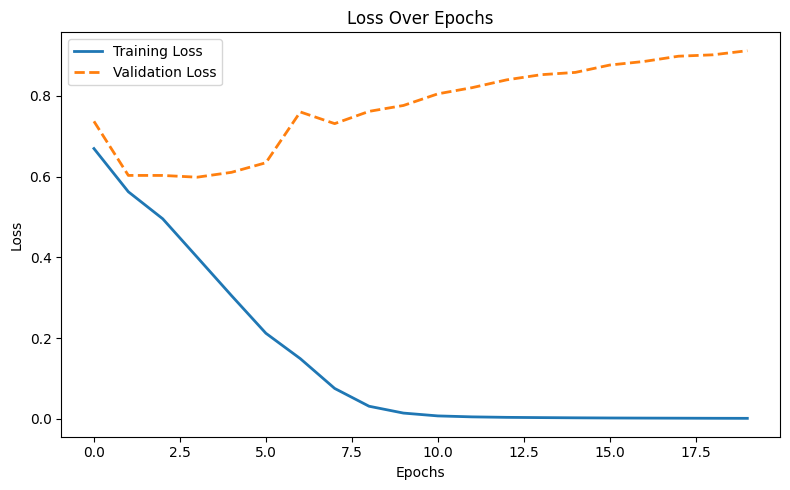

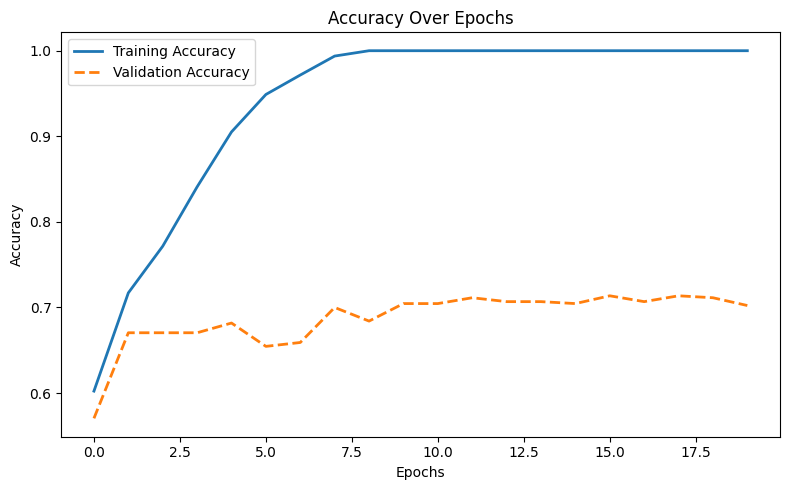

In [20]:
# Calculate elapsed time
training_time = end_time - start_time
print(f"Training completed in {training_time:.2f} seconds.")

# Evaluate on test set
loss, acc = siamese.evaluate(test_file=test_output_path, batch_size=32, analyze=False)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {acc:.4f}')


with open(test_output_path, 'rb') as f:
    (X_test, Y_test, names) = pickle.load(f)

# Convert test data to tensors and transpose to the correct shape
test_data_0 = torch.tensor(X_test[0], dtype=torch.float32).permute(0, 3, 1, 2).to(siamese.device)
test_data_1 = torch.tensor(X_test[1], dtype=torch.float32).permute(0, 3, 1, 2).to(siamese.device)

# Ensure the model is in evaluation mode
siamese.model.eval()

# Generate probabilities
with torch.no_grad():
    outputs = siamese.model(test_data_0, test_data_1).squeeze()
    probabilities = outputs.cpu().numpy()

# Initialize lists for storing examples
examples = {
    'True Positive': [],
    'True Negative': [],
    'False Positive': [],
    'False Negative': []
}

# Find examples for each classification type based on probabilities
for i in range(len(Y_test)):
    true_label = Y_test[i]
    prob = probabilities[i]
    pair_name = names[i]

    if true_label == 1 and prob > 0.5:
        examples['True Positive'].append((pair_name, prob, true_label))
    elif true_label == 0 and prob <= 0.5:
        examples['True Negative'].append((pair_name, prob, true_label))
    elif true_label == 0 and prob > 0.5:
        examples['False Positive'].append((pair_name, prob, true_label))
    elif true_label == 1 and prob <= 0.5:
        examples['False Negative'].append((pair_name, prob, true_label))

# Limit to 15 examples per type
for key in examples:
    examples[key] = sorted(examples[key], key=lambda x: x[1], reverse=(key in ['True Positive', 'False Positive']))[:15]

# Display the examples
for classification, details in examples.items():
    print(f"{classification} Examples:")
    for example in details:
        print(f"Pair: {example[0]}, Model Probability: {example[1]:.2f}, True Label: {example[2]}")
    print()

# Plot loss over epochs
plt.figure(figsize=(8, 5))
plt.plot(history['loss'], label="Training Loss", linewidth=2)
plt.plot(history['val_loss'], label="Validation Loss", linewidth=2, linestyle='--')
plt.title("Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# Plot accuracy over epochs
plt.figure(figsize=(8, 5))
plt.plot(history['accuracy'], label="Training Accuracy", linewidth=2)
plt.plot(history['val_accuracy'], label="Validation Accuracy", linewidth=2, linestyle='--')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()